170500096/170498071 [==============================] - 3s 0us/step
x_train: (50000, 32, 32, 3)
x_train: (50000, 3072)
w1: (3072, 200)
b1: (200,)
iteration : 0/100  , loss: 0.797274  accuracy: 0.375660 
iteration : 10/100  , loss: 0.680464  accuracy: 0.543180 
iteration : 20/100  , loss: 0.615246  accuracy: 0.614860 
iteration : 30/100  , loss: 0.621695  accuracy: 0.646660 
iteration : 40/100  , loss: 0.607268  accuracy: 0.658800 
iteration : 50/100  , loss: 0.586954  accuracy: 0.661820 
iteration : 60/100  , loss: 0.572009  accuracy: 0.663300 
iteration : 70/100  , loss: 0.593953  accuracy: 0.663960 
iteration : 80/100  , loss: 0.600303  accuracy: 0.663960 
iteration : 90/100  , loss: 0.590540  accuracy: 0.664060 
iteration : 100/100  , loss: 0.575348  accuracy: 0.664100 
iteration : 110/100  , loss: 0.551706  accuracy: 0.664140 
iteration : 120/100  , loss: 0.579296  accuracy: 0.664140 
iteration : 130/100  , loss: 0.602052  accuracy: 0.664140 
iteration : 140/100  , loss: 0.577048  a

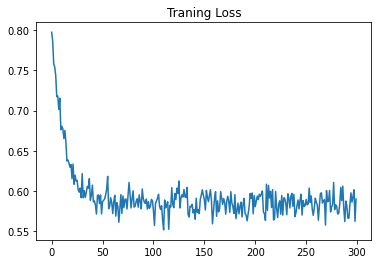

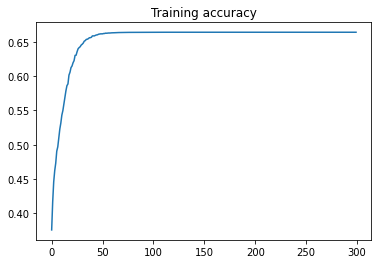

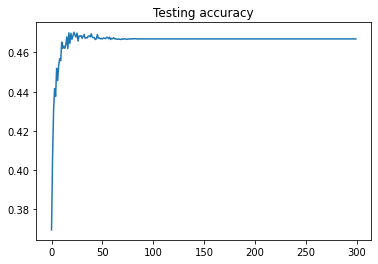

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
print('x_train:', x_train.shape)

K = len(np.unique(y_train)) # Classes
Ntr = x_train.shape[0]
Nte = x_test.shape[0]
Din = 3072 # CIFAR10


mean_image = np.mean(x_train, axis=0)
x_train = x_train - mean_image
x_test = x_test - mean_image
y_train = tf.keras.utils.to_categorical(y_train, num_classes=K)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=K)
x_train = np.reshape(x_train,(Ntr,Din))
x_test = np.reshape(x_test,(Nte,Din))
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
print('x_train:', x_train.shape)

std=1e-5
H=200
w1 = std*np.random.randn(Din, H)
w2 = std*np.random.randn(H, K)
b1 = np.zeros(H)
b2 = np.zeros(K)
print("w1:", w1.shape)
print("b1:", b1.shape)
batch_size = 500
epochs =300
lr =1.4e-2
lr_decay=0.999
reg =5e-6
loss_history = []
train_acc_history = []
val_acc_history = []
seed = 0

for t in range(epochs):
    rng = np.random.default_rng(seed=seed)
    indices = np.arange(Ntr)
    rng.shuffle(indices)    
    x_train_shuffle=x_train[indices] # randomly select the training samples
    y_train_shuffle=y_train[indices]
    iterations=Ntr//batch_size

    for batch_ind in range(iterations): 

        # Forward pass
        x_tr=x_train_shuffle[(batch_ind*batch_size):(batch_ind+1)*batch_size]
        y_tr=y_train_shuffle[(batch_ind*batch_size):(batch_ind+1)*batch_size]
        h=1.0/(1.0 + np.exp(-np.matmul(x_tr,w1)-b1))
        y_pre=np.matmul(h,w2) + b2
        loss=(1/batch_size)*np.square(y_pre-y_tr).sum()  + reg*(np.sum(w1*w1)+np.sum(w2*w2))
        
        # Backward pass
        dy_pre =(1/batch_size)*2.0*(y_pre-y_tr) #derivative of loss with respect to y_pre
        dw2= np.matmul(h.T,dy_pre) +reg*w2  #derivative of loss with respect to w2
        db2=dy_pre.sum(axis=0)  #derivative of loss with respect to b2
        dh=np.matmul(dy_pre,w2.T)
        dw1= np.matmul(x_tr.T,dh*h*(1-h)) +reg*w1   #derivative of loss with respect to w1
        db1=(dh*h*(1-h)).sum(axis=0)         #derivative of loss with respect to b1
        w1-=lr*dw1 #update w1
        w2-=lr*dw2  #update w2
        b1-=lr*db1  #update b1
        b2-=lr*db2  #update b2
        lr*=lr_decay
    loss_history.append(loss)
    seed+=1

    #trainng accuracies
    h_s=1.0/(1.0 + np.exp(-np.matmul(x_train_shuffle,w1)-b1))
    y_pre_s=np.matmul(h_s,w2) + b2
    train_acc=1.0 -(1/Ntr)*np.count_nonzero((np.argmax(y_train_shuffle,axis=1) - np.argmax(y_pre_s,axis=1)))
    train_acc_history.append(train_acc)

    #testing accuracies
    h_test=1.0/(1.0 + np.exp(-np.matmul(x_test,w1)-b1))
    y_test_pre=np.matmul(h_test,w2) + b2
    test_acc= 1.0 - (1/Nte)*np.count_nonzero((np.argmax(y_test,axis=1) - np.argmax(y_test_pre,axis=1)))
    val_acc_history.append(test_acc)

    if t % 10==0:
        print('iteration : %d/%d  , loss: %f  accuracy: %f '% (t,iterations,loss,train_acc))


# Printing accuracies and displaying w as images
plt1=plt.figure(1)
plt.plot(loss_history)
plt.title('Traning Loss')
plt2=plt.figure(2)
plt.plot(train_acc_history)
plt.title('Training accuracy')
plt3=plt.figure(3)
plt.plot(val_acc_history)
plt.title('Testing accuracy')
print('Traning Loss: %f'%(loss_history[-1]))
print('Training accuracy : %f'% (train_acc_history[-1]))
print('Testing accuracy : %f'% (val_acc_history[-1]))


